# Evaluation - sDCG, Effort vs Effect, sRBP #

## TO DOS ##



### Wichtige Hinweise ###

- Pfade müssen gegenenfalls angepasst werden (Suche nach Pfad)
- Für sDCG sind b = 2 und bq = 4 gesetzt (wie in der ursprünglichen Evaluation). Falls die Werte geändert werden sollen: sie befinden sich im Abschnitt 'sDCG' (b_sdcg und bq_sdcg)
- Für die Parameter von sRBP (b und p) werden aktuell mit der Methode von Lipani die besten Werte (basierend auf allen verfügbaren Logdaten) bestimmt und verwendet. Sie können im Abschnitt 'sRBP' aber natürlich auch anders gesetzt werden (b_srbp und p_srbp) (ACHTUNG: Habe sie jetzt doch erstmal festgesetzt, weil mit der Methode p=1 bestimmt wurde, wegen (1-p)*res ist 1 für p aber ein ganz schlechter Wert)
- Aktuell werden die Abbildungen nicht gespeichert. Falls das geändert werden soll, müssen nur überall die Zeilen mit "savefig" einkommentiert werden
- Um zu entscheiden, wie viele Querys in der Evaluation betrachtet werden sollen, gibt die Funktion "querynumber_min_max_avg" die minimale, maximale und durchschnittliche Anzahl der Queries in allen log_files aus. Momentan wird aufgrund der Vergleichbarkeit die minimale Anzahl verwendet. Wenn das geändert werden soll, einfach "querynumber" anpassen
- ACHTUNG: topics_to_analyze beinhaltet alle topics, die in irgendwelchen log-files vorkommen. Sie müssen aber nicht unbedingt in alles vorkommen. Daher muss topics_to_analyze gegebenenfalls angepasst werden
- "levels" sollte nicht verändert werden (enthält alle potentiellen Evaluationslevel, hier also "User" und "Query Strategy", könnte um Modalitäten u.a. erweitert werden, wenn so etwas dazu kommt). c_level kann aber nach Belieben verändert werden (wenn in die Evaluation nicht alle Ausprägungen eines Levels einbezogen werden sollen, sondern nur eine/ein paar bestimmte)
- Weniger wichtig, eher eine Frage: Es war in der ursprünglichen Evaluation so gemacht, dass nur für Dokumente, die der User als relevant markiert hat, überprüft wurde, ob sie relevant sind. Und nur, wenn das der Fall ist, tragen sie zum Ergebnis bei. Ich habe es jetzt genau so gemacht, habe aber trotzdem eine Frage dazu: Geht es bei dieser doppelten Überprüfung darum, den genauen Wert zu bestimmen, da der ja (zumindest bei IWTR) 0, 1 oder 2 sein könnte? Falls nicht, wäre es dann nicht konsequenter, entweder alle Dokumente einzubeziehen, die der User betrachtet hat, unabhängig von der Einordnung, oder die Überprüfung wegzulassen? Aktuell kommen ja nur vom User als relevant markierte und zusätzlich als "korrekt" relevant beurteilte Dokumente ins Ergebnis. Wenn die Einschätzung des Users für die Evaluation zählt, müsste die Relevanz nicht nochmal überprüft werden. Falls die Relevanz der Dokumente betrachtet werden soll, weil der User die Dokumente womöglich unzuverlässig bewertet, sollten dann nicht auch die Dokumente betrachtet werden, die nicht als relevant eingestuft wurden, weil ja auch dabei ein Fehler passiert sein kann?
- bei sRBP lohnt es sich, alle Queries zu betrachten, weil Ergebnisse in späteren Queries so gut wie keinen Einfluss mehr haben. Bei eine querynumber < 10 kann man die Ergebnisse recht gut erkennen
- da es lange dauert, sind plot2 und plot3 bei effeff_all auskommentiert. Wenn man sie doch haben möchte, kann man die Zeilen einfach wieder einkommentieren
- wenn es neue Dateien o.ä. gibt, reicht es jetzt, eine Zelle (die, die mit "log_root_path" startet) auszuführen
- die querynumber ist gerade auf die durschschnittliche Anzahl an Queries pro logfile gesetzt (anstatt Minimum), weil es in den aktuellen Daten logfiles mit nur einer Query gibt
- justfirst lässt sich mit den aktuellen Auswertungen nicht gut darstellen, da sRBP und sDCG je Query angezeigt werden (und bei justfirst gibt es ja nur eine, bei den anderen oft um die 100)
- die Graphen gehen teilweise rauf, runter und wieder rauf aufgrund der unterschiedlichen Anzahlen an Queries. Genauere Beschreibung und Lösungsvorschlag im Abschnitt sDCG

## Vorbereitung ##

In [ ]:
!pip install --upgrade ipywidgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [1]:
# imports
from eval_utils import *

In [2]:
log_root_path = "./sims/output/" # Pfad; Anpassen, falls notwendig
#load all logs
log_files = glob.glob(f"{log_root_path}*.log")

sims = set() # simulations
rankings = set() # ranking methods
topics = set() #
strats = set() # query strategies
users = set() 
crits = set() # reformulation criteria

log_cnt = 0

log_df = pd.DataFrame(columns=['Simulation', 'Ranking', 'Strat', 'User', 'Crit', 'Topics'])

for path in log_files:
    res = get_log_props(path, log_root_path)
    if res:
        log_cnt +=1
        sim, ranking, topic, strat, user, crit = res
        topics.add(topic)
        strats.add(strat)
        users.add(user)
        sims.add(sim)
        rankings.add(ranking)
        crits.add(crit)

        row = {'Simulation' : sim, 'Ranking': ranking, 'Strat' : strat,  'User': user, 'Crit': crit, 'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])

print(f"number of log files: {log_cnt}")
print(f"simulations: {sims}")
print(f"rankings: {rankings}")
print(f"topics: {sorted(topics, key=lambda x: int(x))}")
print(f"strats: {strats}")
print(f"users: {users}")
print(f"crits: {crits}")

print(log_df.groupby(['Simulation', 'Ranking', 'Strat', 'User', 'Crit'])['Topics'].agg(lambda x: len(x)).reset_index())

# ------------------------------

#topics_to_analyze = list(topics)
#topics_to_analyze.sort()

# evaluation levels
levels = [rankings, strats, users, crits]
levelnames = ['Rankings', 'Query Strategies', 'Users', 'Reformulation Criteria']
#levels = [sims, rankings, strats, users, crits]
#levelnames = ['Simulations', 'Rankings', 'Query Strategies', 'Users', 'Reformulation Criteria']

# fixed values for other levels (optional; can be more than one)
c_rankings = {'query_type':['GPT+']}
c_strats = {'user':['perfect']}
c_users = {'query_type':['GPT+'], 'crit':['10rpp'], 'ranking':['bm25']}
c_crits = {}


fixed = [c_rankings, c_strats, c_users, c_crits]

# Relevance judgements
wapo_qrels = relevance_judgements('./data/wapo/wapo_qrels') # Pfad
nyt_qrels = relevance_judgements('./data/nyt/nyt_qrels') # Pfad
# Evaluation
#querynumber: How many queries per session will be considered in the evaluation
querynumber = querynumber_min_max_avg(log_files)[2] # 0: minimum number of queries in all log files, 1: maximum number of queries in all log files, 2: average number of queries (rounded) in all log files

# Querynumber für jedes Maß, damit nicht überall die Anzahl an betrachteten Queries einzeln angepasst werden kann (da bei sRBP kleinere Werte vielleicht sinnvoller sind)
# keine für Effort/Effect, weil da keine benötigt wird
querynumber_sDCG = querynumber
querynumber_sRBP = querynumber 
print(len(topics)) # Um zu überprüfen, ob es alle Topics in allen Kombinationen gibt; aktuell nicht der Fall, jede Kombi gibt es mit 50 Topics, aber insgesamt gibt es 75 Topics, also sind es nicht überall die gleichen


number of log files: 1303
simulations: {'nyt', 'wapo'}
rankings: {'monoT5', 'monoT5cut200', 'monoT5cut500', 'bm25'}
topics: ['307', '310', '321', '325', '330', '336', '341', '344', '345', '347', '350', '353', '354', '355', '356', '362', '363', '367', '372', '375', '378', '379', '389', '393', '394', '397', '399', '400', '404', '408', '414', '416', '419', '422', '423', '426', '427', '433', '435', '436', '439', '442', '443', '445', '614', '620', '626', '646', '677', '690', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825']
strats: {'D2Q', 'GPT', 'D2Q++', 'GPT+', 'justfirst', 'D2Q+'}
users: {'snipsummarytf5', 'navigational', 'snipsummarytf3', 'snipsummarytf4', 'almostrandom', 'informational', 'snipsummarytf6', 'perfect', 'snipsummarytf2'}
crits: {'t100nr', 't150nr', '10rpp', 't50nr'}
   Simulation       Ranking      Strat            User    Crit  Topics
0         nyt 

## sDCG ##

In [3]:
# sDCG parameters
b_sdcg = 2
bq_sdcg = 4

In [4]:
def dcg(results, topic, qrels):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b_sdcg))

    return _dcg

In [69]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, levels, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path) as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')
                                
                            if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':                             
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            if logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                                query_logs[query] = results

                        sdcg = {}
                        _sdcg = 0.0
                        for q, query in enumerate(query_logs.keys()):
                            results = query_logs.get(query)   
                            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
                            sdcg[q+1] = _sdcg
                        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                        #last_sdcg = sdcg[len(sdcg)]
                        #for i in range(len(sdcg)+1,querynumber_sDCG+1):
                        #    sdcg[i] = last_sdcg
                        sdcg_eval_combi[c] = sdcg
                        c += 1
            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber_sDCG].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()

    print('sDCG Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sDCG "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='sDCG', ax = ax1)
            #ax1.set_xlim([0, querynumber_sDCG-1])
            #ax1.set_ylim(bottom = 0)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/sdcg.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


sDCG Evaluation: nyt Users
Combinations used in this evaluation: [['bm25', 'GPT+', 'navigational', '10rpp'], ['bm25', 'GPT+', 'almostrandom', '10rpp'], ['bm25', 'GPT+', 'informational', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


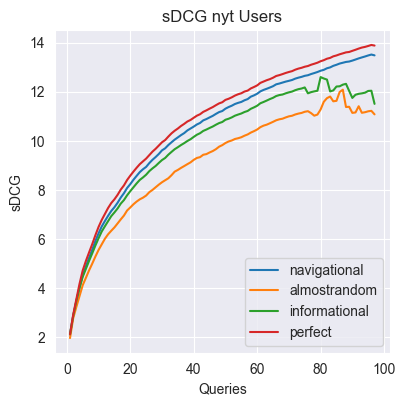

In [70]:
#sDCG_lev('nyt',users, c_users, plot3=True)
#sDCG_lev('wapo',rankings,plot2=True,plot3=True)
sDCG_lev('nyt',users)
# ACHTUNG: Das Ergebnis sieht so schlecht aus, weil es nicht in jedem Dokument so viele Queries gibt (gesetzt ist querynumber = durchschnittliche Anzahl an Queries in den Logdaten)
# Die leeren Werte werden mit 0 aufgefüllt und damit wird dann gemittelt
# Sollte der letzte Wert also weiter durchgezogen werden?? Damit würden Sprünge verhindert werden und der Wert könnte nicht mehr kleiner werden und es würde angeben, dass es
# keinen weiteren Wissensgewinn gibt. Es würde aber auch implizieren, dass mehr Queries eingegeben wurden, die dann nicht erfolgreich waren, was nicht der Fall ist
# Daher ist eigentlich querynumber = Mindestanzahl an Queries besser, weil es das Problem dann nicht gibt, aber da die Mindestanzahl 1 ist, geht das hier nicht

In [14]:
# Auswertung aller logfiles einer Simulation (die hier übergeben werden); OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def sDCG_all(sim, logfiles):
    full_eval = {}
    sdcg_eval = {}
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")

    for f in logfiles:
        log_path = f
            
        query_logs = {}        
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

                if logs[0] == 'INFO': # letzte Query auch noch hinzufügen
                    query_logs[query] = results

        sdcg = {}
        _sdcg = 0.0

        topic = log_path.split('-')[2]

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
            sdcg[q+1] = _sdcg
        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
        #last_sdcg = sdcg[len(sdcg)]
        #for i in range(len(sdcg)+1,querynumber_sDCG+1):
        #    sdcg[i] = last_sdcg
            
        sdcg_eval[f] = sdcg
    full_eval[0] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()

    print('sDCG evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sDCG "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(sdcg_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sDCG, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/sdcg.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

sDCG evaluation of all wapo files
number of sessions: 150
minimum / maximum / average queries per session: [1, 100, 67]


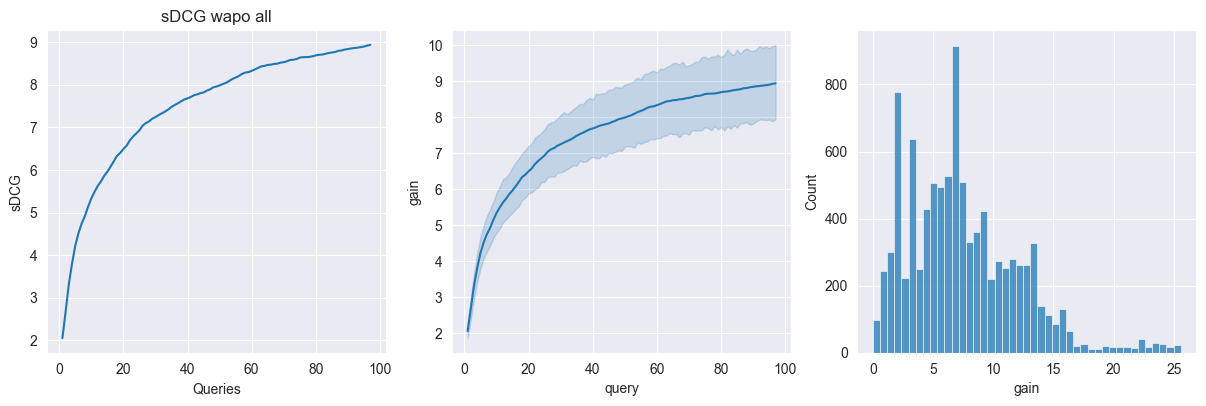

sDCG evaluation of all nyt files
number of sessions: 400
minimum / maximum / average queries per session: [1, 231, 85]


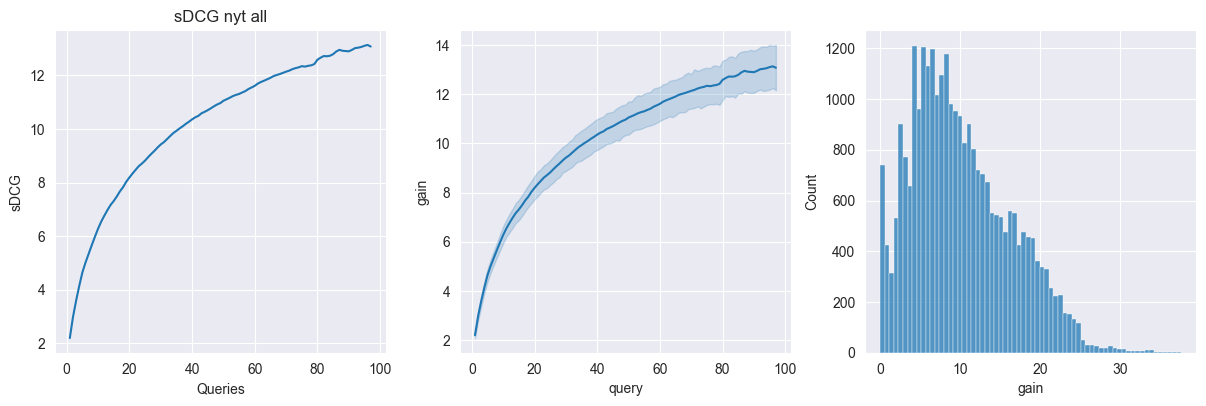

In [13]:
selected_files = filter_logfiles(log_files, sims = 'wapo', rankings = ['monoT5','monoT5cut200']) # filter_logfiles gibt alle Logdateien zur angegebenen Simulation/Simulationen zurück mit den angegebenen Einschränkungen (keine Angabe = alle Ausprägungen)
#selected_files = sim_files('wapo', log_files) # sim_files gibt alle Logdateien zur angegebenen Simulation zurück
sDCG_all('wapo', selected_files)
sDCG_all('nyt',sim_files('nyt',log_files))

## Effort vs. Effect ##

In [42]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    combinations = fixed_combinations(fixed_l, level_index, sim, levels, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)
    
    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    _gain = 0
                    gain = {}  

                    with open(log_path) as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                #if logs[1] == 'SNIPPET':
                                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    
    print('Effect vs. Effort evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("Effort vs Effect "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/effort_effect.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


Effect vs. Effort evaluation: wapo Users
Combinations used in this evaluation: [['bm25', 'GPT+', 'snipsummarytf5', '10rpp'], ['bm25', 'GPT+', 'navigational', '10rpp'], ['bm25', 'GPT+', 'snipsummarytf3', '10rpp'], ['bm25', 'GPT+', 'snipsummarytf4', '10rpp'], ['bm25', 'GPT+', 'almostrandom', '10rpp'], ['bm25', 'GPT+', 'informational', '10rpp'], ['bm25', 'GPT+', 'snipsummarytf6', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'snipsummarytf2', '10rpp']]


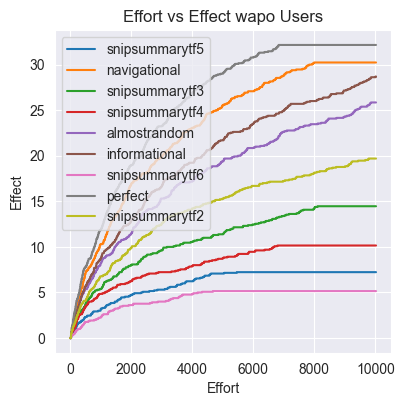

In [46]:
#effeff_lev('wapo',strats, plot2=True)
effeff_lev('wapo', users)

In [48]:
# Auswertung aller logfiles einer Simulation; OHNE verschiedene Eigenschaften, Vergleichbarkeit o.ä. zu betrachten
def effeff_all(sim, logfiles):
    full_eval = {}
    gain_all = {}
    eval_all = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    #allfiles = sim_files(sim, log_files)
    for f in logfiles:
        log_path = f
        topic = log_path.split('-')[2]
            
        _gain = 0
        gain = {}
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')  
                        if qrels.get((topic,result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain

        gain_all[f] = gain
    full_eval[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
    eval_all[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()

    print('Effort vs Effect evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("Effort vs Effect "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', legend=False, ax=ax1)
    #leave out for performance reasons

    #ax2 = fig.add_subplot(1,3,2)
    #eva_df = pd.DataFrame.from_dict(eval_all[0], orient="index").stack().to_frame()
    #eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','cost'])
    #eva_df = eva_df.rename(columns={0:'gain'})
    #eva_df = eva_df[eva_df.apply(lambda row: row['cost'] <= 10000, axis=1)]
    #sns.lineplot(data = eva_df, x='cost',y='gain', ax=ax2)
    #ax3 = fig.add_subplot(1,3,3)
    #sns.histplot(eva_df['gain'], ax= ax3)

    #plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/effort_effect.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

Effort vs Effect evaluation of all nyt files
number of sessions: 400
minimum / maximum / average queries per session: [1, 231, 85]


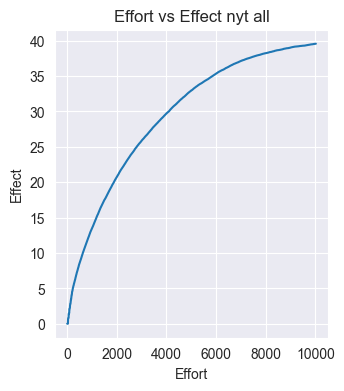

In [49]:
effeff_all('nyt',sim_files('nyt',log_files))

## sRBP ##

In [50]:
# Aldo Lipani sRBP (https://github.com/aldolipani/sRBP/blob/master/main.ipynb)

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def session_based_measure(d, sessions):
    res = 0.0
    for session in sessions:
        n=0 # rank
        m=0 # reformulation
        for event in session:
            if event.startswith('q'):
                m=0
                n=0
            elif event == 'r':
                n=0
                m+=1
            elif event.endswith('-1'):
                res+= d(m, n)
                n+=1
            elif event != 'f':
                n+=1

        res/=len(sessions)

        return res
    
# sRBP for all sessions
def srbp(b, p, sessions):
    return (1-p)*session_based_measure(lambda m, n : d_srbp(b, p, m, n), sessions)
# 1 - p: normalization factor

In [51]:
# b_p_srbp(log_files): determine best b and p for sRBP based on the log data (using all log-files for overall value or a specific part for example for one simulation)
# the code is from Aldo Lipani (https://github.com/aldolipani/sRBP/blob/master/main.ipynb) and only slightly modified to fit the log-file format
# returns best_b, best_p
def b_p_srbp(log_files):

    max_reformulation = 0
    max_rank = 0

    # determine max reformulation and max rank
    for log_file in log_files:
        m = -1 # -1 statt 0, weil bei der ersten Query (also Erstformulierung, nicht NEUformulierung) schon der Wert erhöht wird; im Original (von Lipani) lässt sich die erste Query einer Session von den anderen unterscheiden
        n = 0
        with open(log_file) as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                    if m > max_reformulation:
                        max_reformulation = m
                if parts[1] == 'SNIPPET':
                    n += 1
                    if n > max_rank:
                        max_rank = n

            
    count = [[0] * max_rank for i in range(max_reformulation+1)]
    for log_file in log_files:
        m = -1 # s.o.
        n = 0
        with open(log_file) as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                if parts[1] == 'SNIPPET':
                    count[m][n] += 1
                    n += 1
            
    df = pd.DataFrame(count)
    df = df/df.values.sum()
    gt = df.values
    df.transpose()

    M = gt.shape[0]
    N = gt.shape[1]

    min_err = sys.float_info.max
    res = 100
    best_p = -1
    best_b = -1
    grid = {}

    def tse_srbp(b, p):
        norm = 0.0
        for i in range(M*N):
            norm += d_srbp(b, p, i//N, i%N)
        err = 0.0
        for i in range(M*N):
            err += (gt[i//N, i%N]-d_srbp(b, p, i//N, i%N)/norm)**2
        return err

    t = tqdm(np.linspace(0, 1, res+1), desc = "TSE: {:.4f}".format(min_err))
    for p_i, p in enumerate(t):

        grid[p_i] = []
        for b in np.linspace(0, 1, res+1):
            
            err = tse_srbp(b, p)
            
            grid[p_i].append(err)

            if err < min_err:
                min_err = err
                best_p = p
                best_b = b
                t.set_description("TSE: {:.4f}".format(min_err))

    grid = pd.DataFrame.from_dict(grid)

    srbp_best_b = best_b
    srbp_best_p = best_p

    print("b =", best_b, ", p =", best_p, ", TSE = {:.4f}".format(min_err))
    return best_b, best_p

In [19]:
!pip show tqdm 

Name: tqdm
Version: 4.65.0
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPLv2.0, MIT Licences
Location: C:\Users\janaf\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: colorama
Required-by: ir-datasets, nltk, python-terrier


In [52]:
# sRBP parameters
p_srbp = 0.8 # persistence parameter (Wahrscheinlichkeit, die Suche fortzusetzen)
b_srbp = 0.6 # balance parameter (Balance zwischen "das nächste Element betrachten" und "die Query neu formulieren")
#b_srbp, p_srbp = b_p_srbp(log_files) # b und p basierend auf den logfiles

# ACHTUNG! Bei den aktuellen Daten wurde 1 als Wert für best_p berechnet. Da das Ergebnis allerdings mit (1-p) multipliziert wird, ist das Ergebnis dann immer 0 und damit nicht aussagekräftig

In [53]:
# sRBP value for one session (using discount function from Lipani)
def s_rbp(b, p, log_path, topic, qrels):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path) as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count; DOCUMENT is not relevant here because it is just repeated after SNIPPET
                n += 1
                                
            elif logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT': # add d_srbp value for relevant document to the result
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res += d_srbp(b, p, m, n)
                        #print('dsrbp: ' + str(d_srbp(b,p,m,n)))
                        #print('res: ' + str(res))

    return (1-p)*res, query_rbp # return sRBP for whole session, list of sRBP values after each query

In [75]:
def sRBP_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    combinations = fixed_combinations(fixed_l, level_index, sim, levels, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    existing_levels = [l for l in levels[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1] 

                    # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
                    #last_srbp = srbp[len(srbp)-1]
                    #for i in range(len(srbp),querynumber_sRBP):
                    #    srbp[i] = last_srbp    

                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber_sRBP].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    print('sRBP Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sRBP "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/srbp.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


sRBP Evaluation: wapo Rankings
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


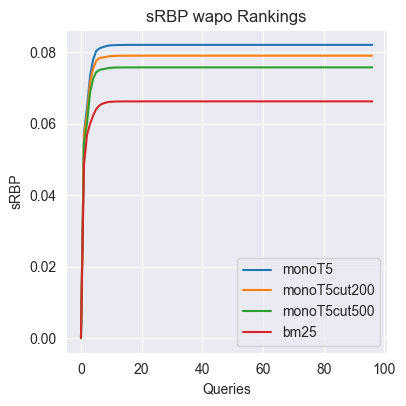

In [78]:
#sRBP_lev('wapo', rankings, plot2=True,plot3=True)

sRBP_lev('wapo', rankings)

In [79]:
# sRBP Wert für alle übergebenen logfiles (ohne auf Usertyp o.ä. einzugehen)
def sRBP_all(sim, logfiles):

    full_eval = {}
    srbp_eval = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    #allfiles = sim_files(sim, log_files)
    for f in logfiles:
        log_path = f
        
        topic = log_path.split('-')[2]

        srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1]
        
        # ACHTUNG Diesen Teil einkommentieren, wenn der letzte Wert "mitgezogen" werden soll, um einen Abfall des Werts und Sprünge zu verhindern (s. nächste Zelle)
        #last_srbp = srbp[len(srbp)-1]
        #for i in range(len(srbp),querynumber_sRBP):
        #    srbp[i] = last_srbp 

        srbp_eval[f] = srbp
    
    full_eval[0] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()

    print('sRBP evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sRBP "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(srbp_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sRBP, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/srbp.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

sRBP evaluation of all nyt files
number of sessions: 400
minimum / maximum / average queries per session: [1, 231, 85]


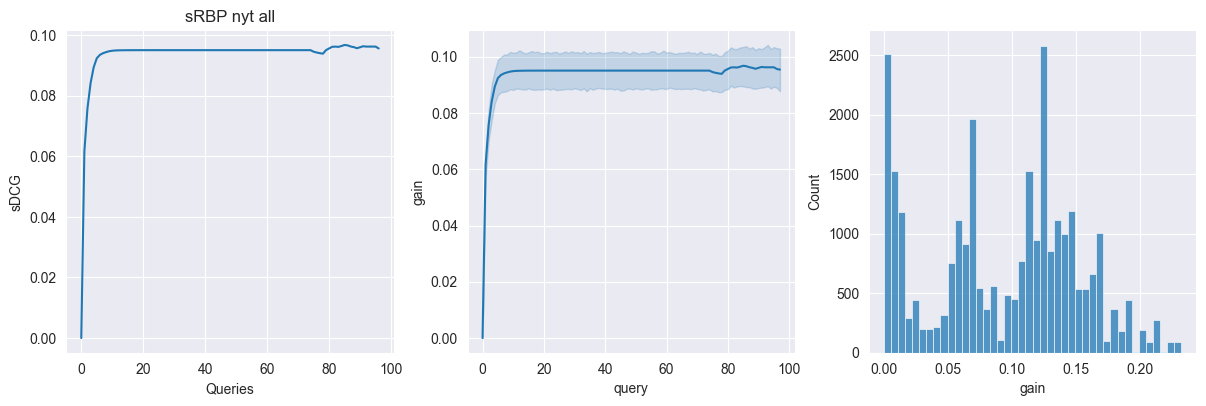

In [81]:
sRBP_all('nyt',sim_files('nyt',log_files))

## Evaluation ##

In [127]:
# Gesamte Evaluation: Es werden alle Graphen gezeigt für jedes Evaluationslevel und jede Simulation (auf Levelebene und allgemein)
def full_evaluation():
    for sim in sims:
        print(sim)
        sDCG_all(sim, sim_files(sim,log_files))
        effeff_all(sim, sim_files(sim,log_files))
        sRBP_all(sim, sim_files(sim,log_files))
        for level in levels:
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)

# ANMERKUNG: Wenn man (sDCG/effeff/sRBP)_all so verwendet wie hier und einfach alle Logdateien übergibt, kann das Ergebnis, sobald es mehrere Usertypen und Strategien gibt,
# natürlich sehr schwierig zu interpretieren und zu vergleichen sein. Man kann aber vorher die Logdateien herausfiltern, die man übergeben möchte, und sie dann gezielt auswerten.



In [128]:
# Gesamte Evaluation für eine ausgewählte Simulation
def sim_evaluation(sim):
    print(sim)
    for level in levels:
            #sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
    sDCG_all(sim, sim_files(sim,log_files))
    effeff_all(sim, sim_files(sim,log_files))
    sRBP_all(sim, sim_files(sim,log_files))

wapo
sDCG Evaluation: wapo Rankings
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


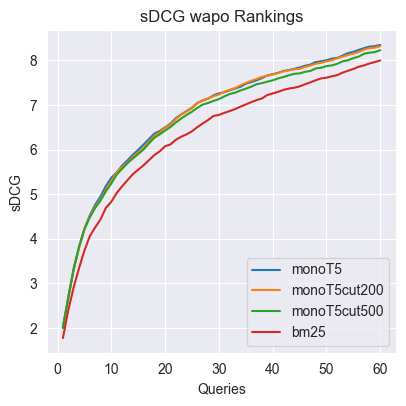

Effect vs. Effort evaluation: wapo Rankings
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


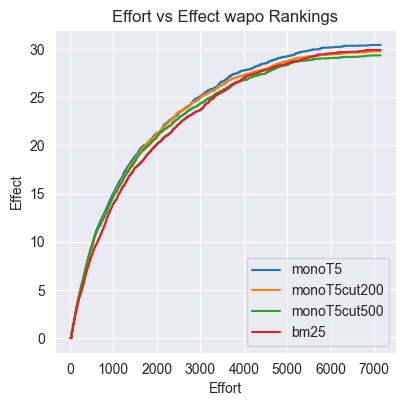

sRBP Evaluation: wapo Rankings
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


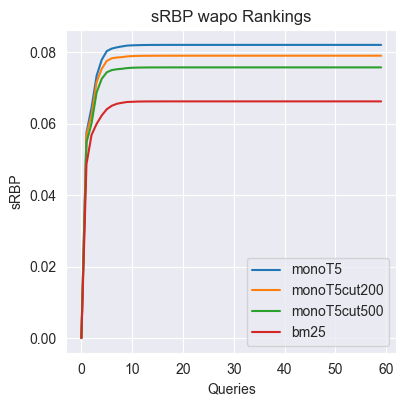

sDCG Evaluation: wapo Query Strategies
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


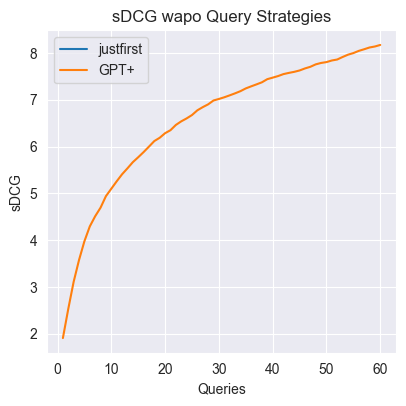

Effect vs. Effort evaluation: wapo Query Strategies
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


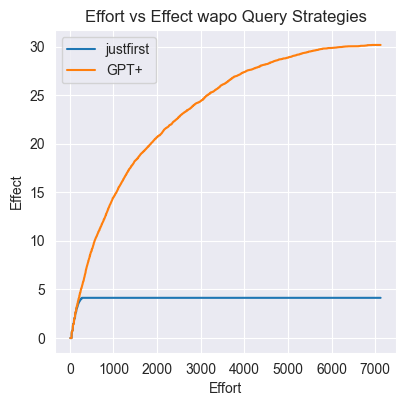

sRBP Evaluation: wapo Query Strategies
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


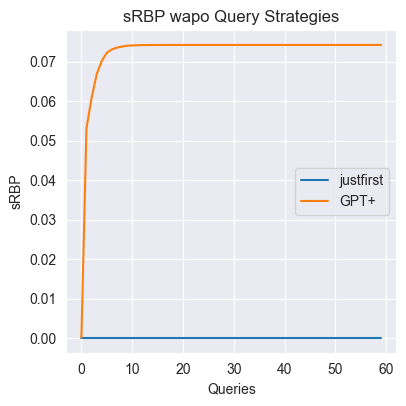

sDCG Evaluation: wapo Users
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp']]


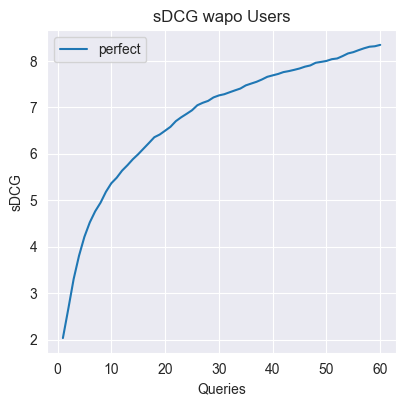

Effect vs. Effort evaluation: wapo Users
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp']]


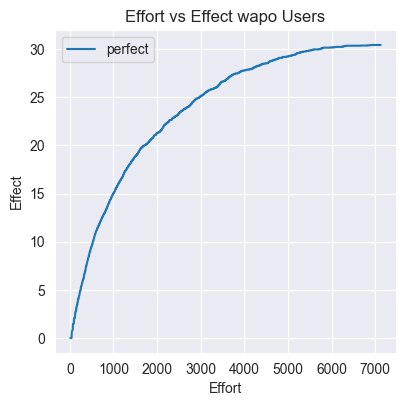

sRBP Evaluation: wapo Users
Combinations used in this evaluation: [['monoT5', 'GPT+', 'perfect', '10rpp']]


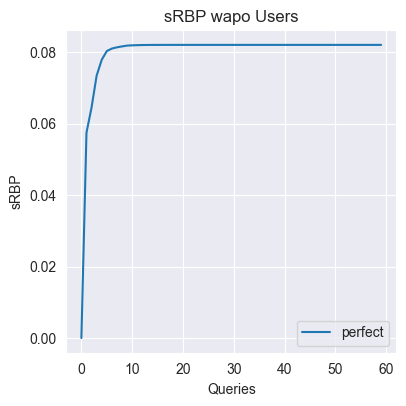

sDCG Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


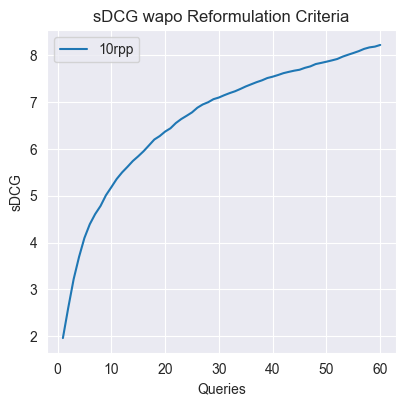

Effect vs. Effort evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


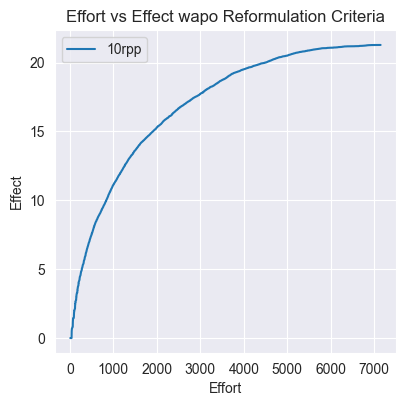

sRBP Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['monoT5', 'justfirst', 'perfect', '10rpp'], ['monoT5', 'GPT+', 'perfect', '10rpp'], ['monoT5cut200', 'GPT+', 'perfect', '10rpp'], ['monoT5cut500', 'GPT+', 'perfect', '10rpp'], ['bm25', 'justfirst', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp']]


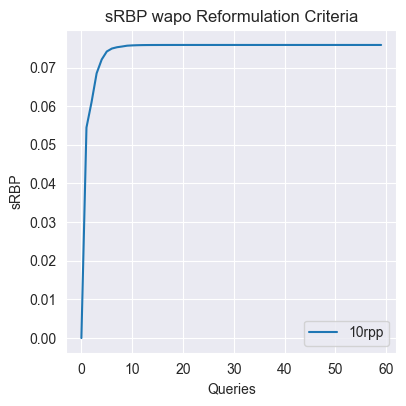

sDCG evaluation of all wapo files
number of sessions: 300
minimum / maximum / average queries per session: [1, 100, 67]


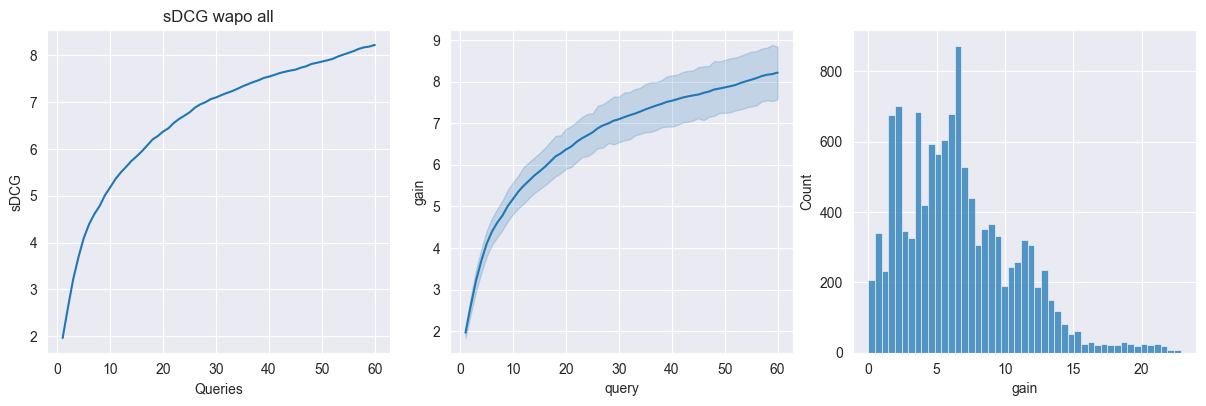

Effort vs Effect evaluation of all wapo files
number of sessions: 300
minimum / maximum / average queries per session: [1, 100, 67]


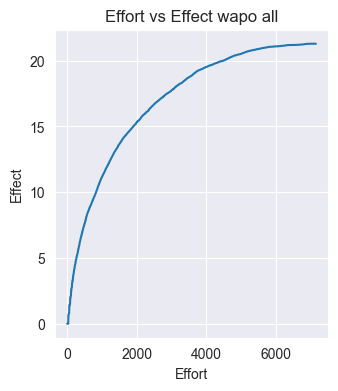

sRBP evaluation of all wapo files
number of sessions: 300
minimum / maximum / average queries per session: [1, 100, 67]


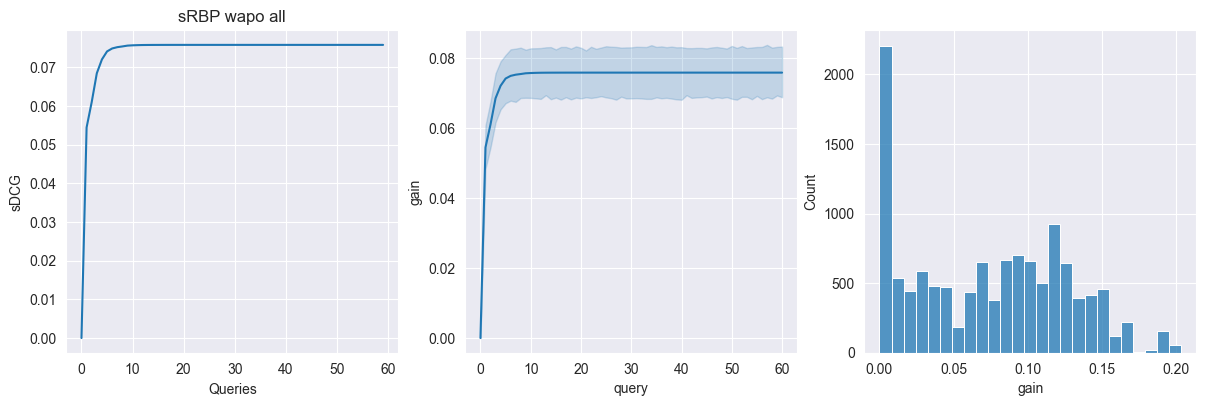

In [129]:
sim_evaluation('wapo')

Effort vs Effect evaluation of all wapo files
number of sessions: 300
minimum / maximum / average queries per session: [1, 100, 67]


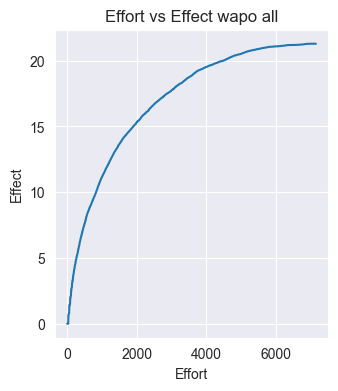

In [130]:
# Beispiele 
#sDCG_lev('wapo_sim', users, c_users, plot1=True, plot2=False, plot3=False)
#effeff_lev('sim_wapo_bm25', strats, c_strats, plot1=True, plot2=True, plot3=True)
#sRBP_lev('wapo_sim', users, c_users, plot1=True, plot2=False, plot3=False)
effeff_all(sim, log_files)
#full_evaluation()
#sim_evaluation('sim_wapo_bm25')